# $Import$

In [1]:
import numpy as np
import itertools
import re
import copy
from itertools import product
import matplotlib.pyplot as plt
from mindquantum.core.gates import H, Z, X, Rzz, RZ, RY, RX, Rxx, Ryy, Rxy, Rxz, Ryz, Rn, S, Y, CNOT
from mindquantum.simulator import Simulator
from mindquantum.core.circuit import Circuit
from mindquantum.core.parameterresolver import ParameterResolver
from mindquantum.core.operators import QubitOperator, Hamiltonian, commutator
from scipy.optimize import minimize

# $Functions$

### 1.Maxcut or Ising Model

In [2]:
def weight_matrix_maxcut(nbit):
    mat = np.zeros((nbit, nbit))
    for ii in range(nbit):
        for jj in range(nbit):
            if jj > ii: mat[ii, jj] = np.random.uniform(0, 1)
    return mat + mat.T

def weight_matrix_ising(nbit):
    mat = np.zeros((nbit, nbit))
    for ii in range(nbit):
        for jj in range(nbit):
            if jj >= ii: mat[ii, jj] = np.random.uniform(-1, 1)
    return mat

### 2.get the Hamiltonian

In [3]:
def weights_vector(combis, W):
    weights = []
    for combi in combis:
        weights.append(W[combi])
    return weights

def get_ham(nbit, W):
    combis = list(itertools.combinations_with_replacement(range(nbit), 2))
    wvec = weights_vector(combis, W)
    ham_op = QubitOperator()
    for w, (i, j) in zip(wvec, combis):
        if i == j:
            ham_op += QubitOperator(f'Z{i}', w)
        if i != j:
            ham_op += QubitOperator(f'Z{i} Z{j}', w)
    return ham_op

### 3.Mixers Pool

In [4]:
def mixer_double(nbit):
    number_pairs = [f'{i}{j}' for i in range(nbit) for j in range(i + 1, nbit)]
    letter_pairs = ['Y Z', 'Z Y', 'X Y', 'Y X', 'X Z', 'Z X', 'X X', 'Y Y', 'Z Z']
    pool = [f'{let[0]}{num[0]} {let[2]}{num[1]}' for num, let in product(number_pairs, letter_pairs)]
    return pool
def mixer_single(nbit):
    pool = []
    pool.extend([f'X{i}' for i in range(nbit)])
    pool.extend([f'Y{i}' for i in range(nbit)])

    pool.append(' '.join([f'X{i}' for i in range(nbit)]))
    pool.append(' '.join([f'Y{i}' for i in range(nbit)]))
    return pool

def mixer_pool(nbit):
    number_pairs = [f'{i}{j}' for i in range(nbit) for j in range(i + 1, nbit)]
    letter_pairs = ['Y Z', 'Z Y', 'X Y', 'Y X']
    pool = [f'{let[0]}{num[0]} {let[2]}{num[1]}' for num, let in product(number_pairs, letter_pairs)]
    return pool

### 4.add a layer of mixer

In [5]:
def qaoa_mixer(circ, mixer_str, beta, nodes):
    letters = re.findall(r'[A-Z]', mixer_str)
    numbers = re.findall(r'\d+', mixer_str)
    letters_str = ''.join(letters)
    nums = [int(num) for num in numbers]
    pr = ParameterResolver({beta: 2})
    # Single qubit mixer
    if letters_str == 'X':
        circ += RX(pr).on(nums)
    if letters_str == 'Y':
        circ += RY(pr).on(nums)
    # All qubit mixer
    if letters_str == 'X' * nodes:
        for i in range(nodes):
            circ += RX(pr).on(i)
    if letters_str == 'Y' * nodes:
        for i in range(nodes):
            circ += RY(pr).on(i)
    # Double qubit mixer
    if letters_str == 'XX':
        circ += Rxx(pr).on(nums)
    if letters_str == 'YY':
        circ += Ryy(pr).on(nums)
    if letters_str == 'ZZ':
        circ += Rzz(pr).on(nums)
    if letters_str == 'YZ':
        circ += Ryz(pr).on(nums)
    if letters_str == 'ZY':
        circ += Ryz(pr).on(nums[::-1])
    if letters_str == 'XY':
        circ += Rxy(pr).on(nums)
    if letters_str == 'YX':
        circ += Rxy(pr).on(nums[::-1])
    if letters_str == 'XZ':
        circ += Rxz(pr).on(nums)
    if letters_str == 'ZX':
        circ += Rxz(pr).on(nums[::-1])
    circ.barrier()

### 5.get the gradient

In [6]:
def derivative(ham_op, nodes, mixer, circ):
    commu = (-1j) * commutator(ham_op, QubitOperator(mixer))
    sim = Simulator("mqvector", nodes)
    expectation = sim.get_expectation(Hamiltonian(commu), circ)
    return expectation.real

def derivative_s(ham_op, nodes, mixer, circ):
    sim = Simulator('stabilizer', nodes)
    commu = (-1j) * commutator(ham_op, QubitOperator(mixer))
    expectation = sim.get_expectation(Hamiltonian(commu), circ)
    return expectation.real

### 6.Optimization

In [7]:
def optimize(ham_op, circ, nodes, theta):
    ham = Hamiltonian(ham_op)
    sim = Simulator('mqvector', nodes)
    grad_ops = sim.get_expectation_with_grad(ham, circ)

    if len(theta) < 1:
        p0 = np.array([0.0])
    else:
        p = np.array(list(theta.values()))
        p0 = np.append(p, [0.0])

    def fun(p, grad_ops):
        f, g = grad_ops(p)
        f = np.real(f)[0, 0]
        g = np.real(g)[0, 0]
        return f,g

    res = minimize(fun, p0, args=(grad_ops,), method='bfgs', jac=True)

    return dict(zip(circ.params_name, res.x)), res.fun

### 7.get the expectation

In [9]:
def get_exp(ham_op, nbit, circ):
    sim = Simulator('stabilizer', nbit)
    expectation = sim.get_expectation(Hamiltonian(ham_op), circ)
    return expectation.real

### 8.Extract the qubits and gates from mixer_string

In [8]:
def extract(mixer_str):
    letters = re.findall(r'[A-Z]', mixer_str)
    numbers = re.findall(r'\d+', mixer_str)
    letters_str = ''.join(letters)
    nums = [int(num) for num in numbers]
    return letters_str, nums

### 9.add a Clifford layer of "XY" or "YZ"

In [10]:
def add_layer_yz(circ, l, m):
    circ += Z.on(l)
    circ += S.on(l)

    circ += H.on(m)
    circ.barrier()
    circ += CNOT(m, l)
    circ.barrier()

    circ += S.on(l)
    circ += H.on(l)
    circ += S.on(l)

    circ.barrier()
    circ += CNOT(m, l)
    circ.barrier()
    circ += S.on(l)

    circ += H.on(m)
    circ.barrier()
def add_layer_xy(circ, l, m):
    circ += Z.on(m)
    circ += S.on(m)

    circ.barrier()
    circ += CNOT(l, m)
    circ.barrier()

    circ += S.on(m)
    circ += H.on(m)
    circ += S.on(m)

    circ.barrier()
    circ += CNOT(l, m)
    circ.barrier()
    circ += S.on(m)


    circ.barrier()

# $Algorithms$

### 1. get the ground state energy(N<=10)
穷举法硬解 Maxcut 或 Ising 问题

In [11]:
def compute_ground_state_energy(W, nbit):
    ham = get_ham(nbit, W)
    mat = ham.matrix().toarray().real
    n = len(W)
    g = np.array([
        [1],
        [0]
    ])
    e = np.array([
        [0],
        [1]
    ])
    states = [g, e]
    basis_vectors = []
    for comb in itertools.product(states, repeat=n):
        vector = comb[0]
        for state in comb[1:]:
            vector = np.kron(vector, state)
        basis_vectors.append(vector)
    exps = [(vector.T @ mat @ vector)[0][0] for vector in basis_vectors]
    return min(exps)

### 2. Adapt-QAOA without standard layer
仅用混合层优化的 Adapt-QAOA 算法

In [12]:
def ADAPT_QAOA_mixerlayer_only(ham_op, nodes, pool, layers):
    circ = Circuit().un(H,range(nodes))
    k = 0
    theta = {}
    mixers_used = []
    allthemin = [0]

    while True:
        if k == layers:
            return theta, allthemin, circ, mixers_used
        gradients = []
        circ_grad = copy.deepcopy(circ.apply_value(theta))

        for mixer in pool:
            gradients.append(abs(derivative(ham_op, nodes, mixer, circ_grad)))
        mixers_used.append(pool[np.argmax(gradients)])

        k += 1
        qaoa_mixer(circ, mixers_used[-1], f'b{k}', nodes)
        result, qubo_min = optimize(ham_op, circ, nodes, theta)
        theta = result
        allthemin.append(qubo_min)

### 3. Adapt Clifford to Ising with pool

In [13]:
def adapt_clifford_ising_with_pool(nbit, f, ham_op, pool, layers):
    circ = Circuit().un(H, range(nbit)).z(f)

    l = 0
    mixers_used = []
    exps = [0]

    while True:
        grad = [derivative(ham_op, nbit, mixer, circ) for mixer in pool]
        mixer, qubits = extract(pool[np.argmax(grad)])
        mixers_used.append(pool[np.argmax(grad)])

        if mixer == 'XY':
            add_layer_xy(circ, qubits[0], qubits[1])
        elif mixer == 'YX':
            add_layer_xy(circ, qubits[1], qubits[0])
        elif mixer == 'YZ':
            add_layer_yz(circ, qubits[0], qubits[1])
        elif mixer == 'ZY':
            add_layer_yz(circ, qubits[1], qubits[0])

        exps.append(get_exp(ham_op, nbit, circ))
        l += 1
        if l == layers:
            return mixers_used, exps, circ

### 4. Algorithm A
由 N-1 层 “XY” 和最后一层 “YZ” 构成

若将 Y 作用的比特视为 “激活” 比特，算法 A 对初始比特 k 的 “激活” 可能发生在任意层

In [14]:
def function_algorithm_A(W, ham_op, f):
    nbit = len(W)
    circ = Circuit().un(H, range(nbit)).z(f)

    lst = W.diagonal().tolist()
    lst[f] = -np.inf
    q = np.argmax(lst)
    add_layer_xy(circ, f, int(q))
    
    active = [q]
    inactive = [i for i in range(n) if i != q]

    l = 1
    mixers_used = [f"Y{q} X{f}"]
    exps = [0, get_exp(ham_op, nbit, circ)]

    while True:
        pool = [f'Y{i} X{j}' for i in inactive for j in inactive if i != j]
        grad = [derivative_s(ham_op, nbit, mixer, circ) for mixer in pool]
        mixer = pool[np.argmax(grad)]
        _, qubits = extract(mixer)
        add_layer_xy(circ, qubits[1], qubits[0])

        active.append(qubits[0])
        inactive.remove(qubits[0])

        exps.append(get_exp(ham_op, nbit, circ))
        mixers_used.append(mixer)
        
        l += 1
        
        if l == nbit-1:
            pool = [f'Y{inactive[0]} Z{i}' for i in active]
            grad = [derivative_s(ham_op, nbit, mixer, circ) for mixer in pool]
            mixer = pool[np.argmax(grad)]
            _, qubits = extract(mixer)
            add_layer_yz(circ, qubits[0], qubits[1])

            exps.append(get_exp(ham_op, nbit, circ))
            mixers_used.append(mixer)

            l += 1

            return mixers_used, exps, circ

### 5. Algorithm B
由 N-1 层 “XY” 和最后一层 “YZ” 构成

若将 Y 作用的比特视为 “激活” 比特，算法B 对初始比特 k 的 “激活” 一定发生在最后两层

In [15]:
def function_algorithm_B(W, ham_op, f):
    nbit = len(W)
    circ = Circuit().un(H, range(nbit)).z(f)

    lst = W.diagonal().tolist()
    lst[f] = -np.inf
    q = int(np.argmax(lst))
    add_layer_xy(circ, f, q)
    
    active = [q]
    inactive = [i for i in range(n) if i != q]

    l = 1
    mixers_used = [f"Y{q} X{f}"]
    exps = [0, get_exp(ham_op, nbit, circ)]

    while True:
        pool = [f'Y{i} X{j}' for i in inactive for j in inactive if i != j and i != f]
        grad = [derivative_s(ham_op, nbit, mixer, circ) for mixer in pool]
        mixer = pool[np.argmax(grad)]
        _, qubits = extract(mixer)
        add_layer_xy(circ, qubits[1], qubits[0])

        active.append(qubits[0])
        inactive.remove(qubits[0])

        exps.append(get_exp(ham_op, nbit, circ))
        mixers_used.append(mixer)
        
        l += 1
        if l == nbit-2:
            a, b = inactive
            pool = [f"Y{a} X{b}", f"Y{b} X{a}"]
            grad = [derivative_s(ham_op, nbit, mixer, circ) for mixer in pool]
            mixer = pool[np.argmax(grad)]
            _, qubits = extract(mixer)
            add_layer_xy(circ, qubits[1], qubits[0])

            active.append(qubits[0])
            inactive.remove(qubits[0])
    
            exps.append(get_exp(ham_op, nbit, circ))
            mixers_used.append(mixer)

            l += 1
        if l == nbit-1:
            pool = [f'Y{inactive[0]} Z{i}' for i in active]
            grad = [derivative_s(ham_op, nbit, mixer, circ) for mixer in pool]
            mixer = pool[np.argmax(grad)]
            _, qubits = extract(mixer)
            add_layer_yz(circ, qubits[0], qubits[1])

            exps.append(get_exp(ham_op, nbit, circ))
            mixers_used.append(mixer)

            l += 1
            return mixers_used, exps, circ

# $Figure$ 1&2

### 1. Test Maxcut to Clifford
只有 “YZ” 对能量下降有贡献

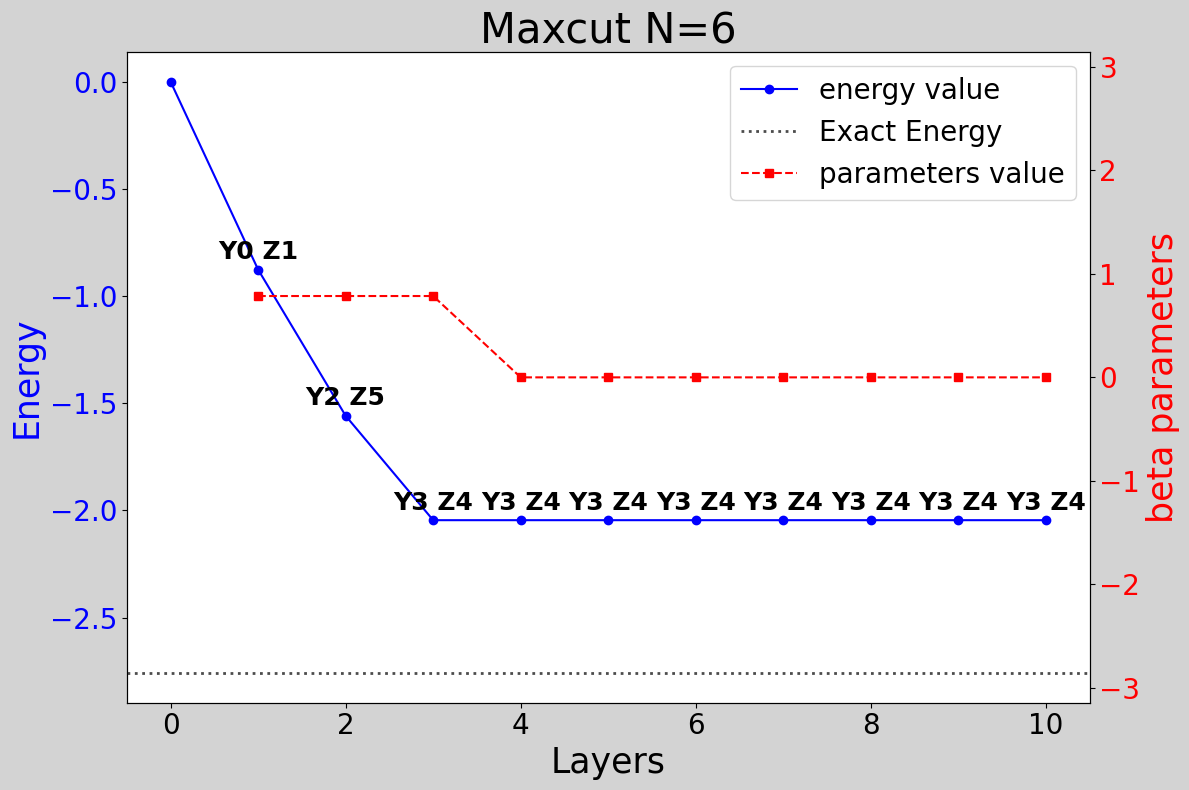

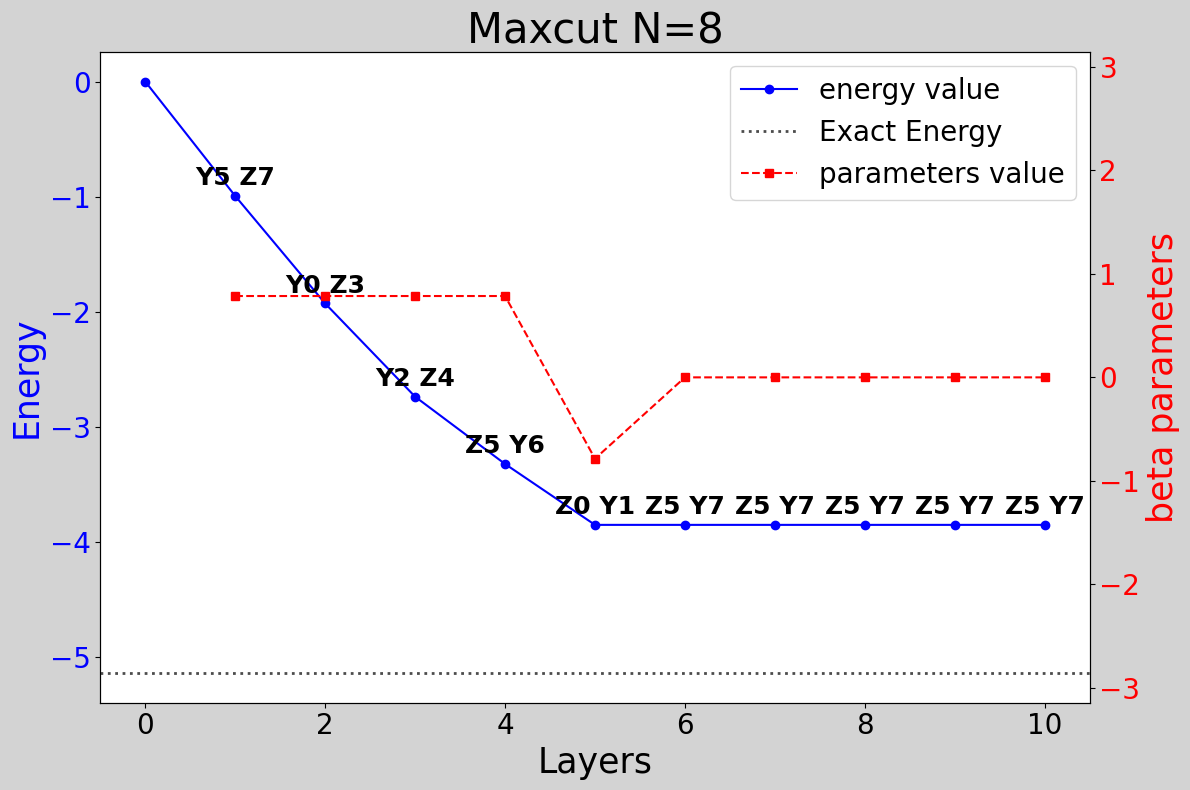

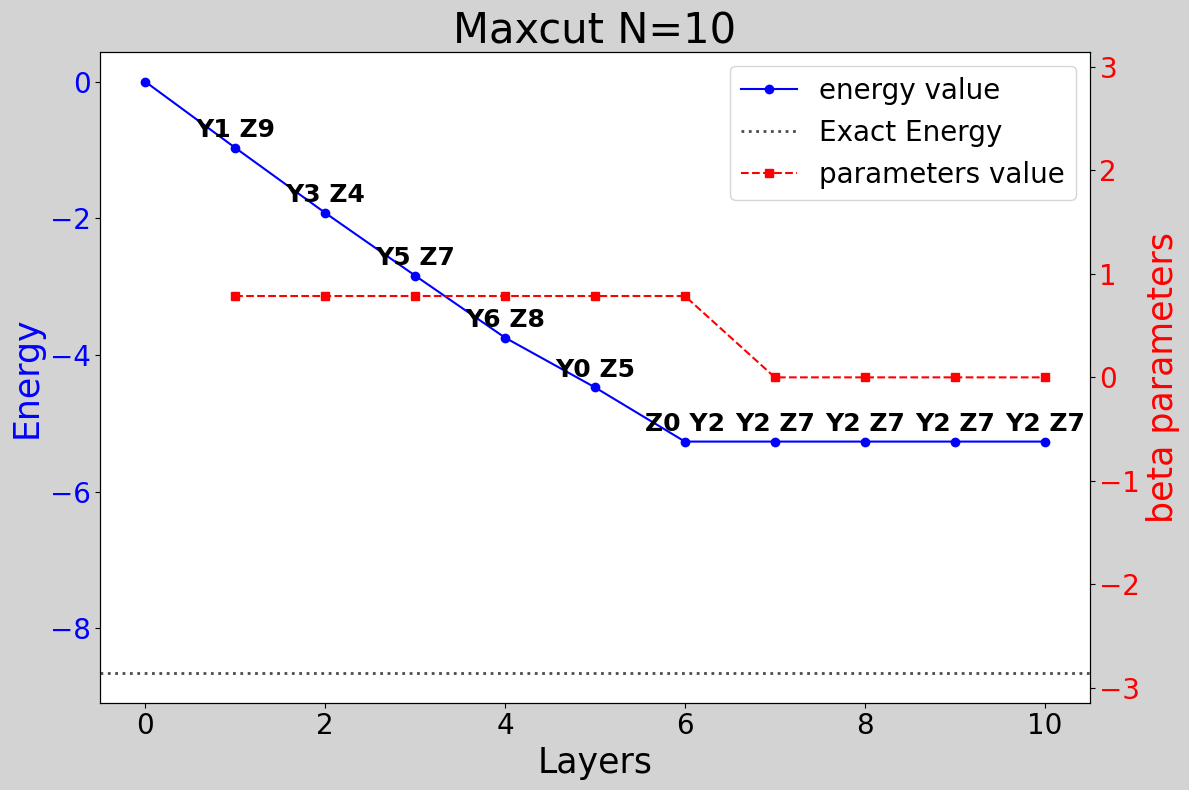

In [16]:
for nbit, layers in [[6,10], [8,10], [10,10]]:
    for i in range(1):
        W = weight_matrix_maxcut(nbit)
        ham_op = get_ham(nbit, W)
        pool = mixer_double(nbit) + mixer_single(nbit)
        energy = compute_ground_state_energy(W, nbit)
        theta, allthemin, _, mixers_used = ADAPT_QAOA_mixerlayer_only(ham_op, nbit, pool, layers)
    
        fig, ax1 = plt.subplots(figsize=(12, 8), facecolor='lightgray')
    
        ax1.plot(list(range(layers+1)), allthemin, color='b', marker='o', label='energy value')
        ax1.set_xlabel('Layers', fontsize=25)
        ax1.set_ylabel('Energy', fontsize=25, color='b')
        ax1.tick_params(axis='y', labelcolor='blue',labelsize=20)
        ax1.tick_params(axis='x', labelcolor='black',labelsize=20)
        ax1.axhline(y=energy, color='black', linestyle=':', linewidth=2, alpha=0.7, label='Exact Energy')
    
        for x, y, mixer in zip(list(range(1,layers+1)), allthemin[1:], mixers_used):
            ax1.annotate(mixer, xy=(x, y), xytext=(0, 4),
                            textcoords='offset points',
                            ha='center', va='bottom',
                            fontsize=18, color='black',weight='bold')
    
        ax2 = ax1.twinx()
        ax2.plot(list(range(1, layers+1)), [round(num, 4) for num in list(theta.values())],
                         's--', color='r', label='parameters value')
        ax2.set_ylabel('beta parameters', color='red', fontsize=25)
        ax2.tick_params(axis='y', labelcolor='red',labelsize=20)
        ax2.set_ylim(-np.pi, np.pi)
    
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=20)
    
        plt.title(f'Maxcut N={nbit}', fontsize=30)
        plt.tight_layout()
        plt.show()

### 2. Test Ising to Clifford
“YZ” “XY” 对能量下降均有贡献

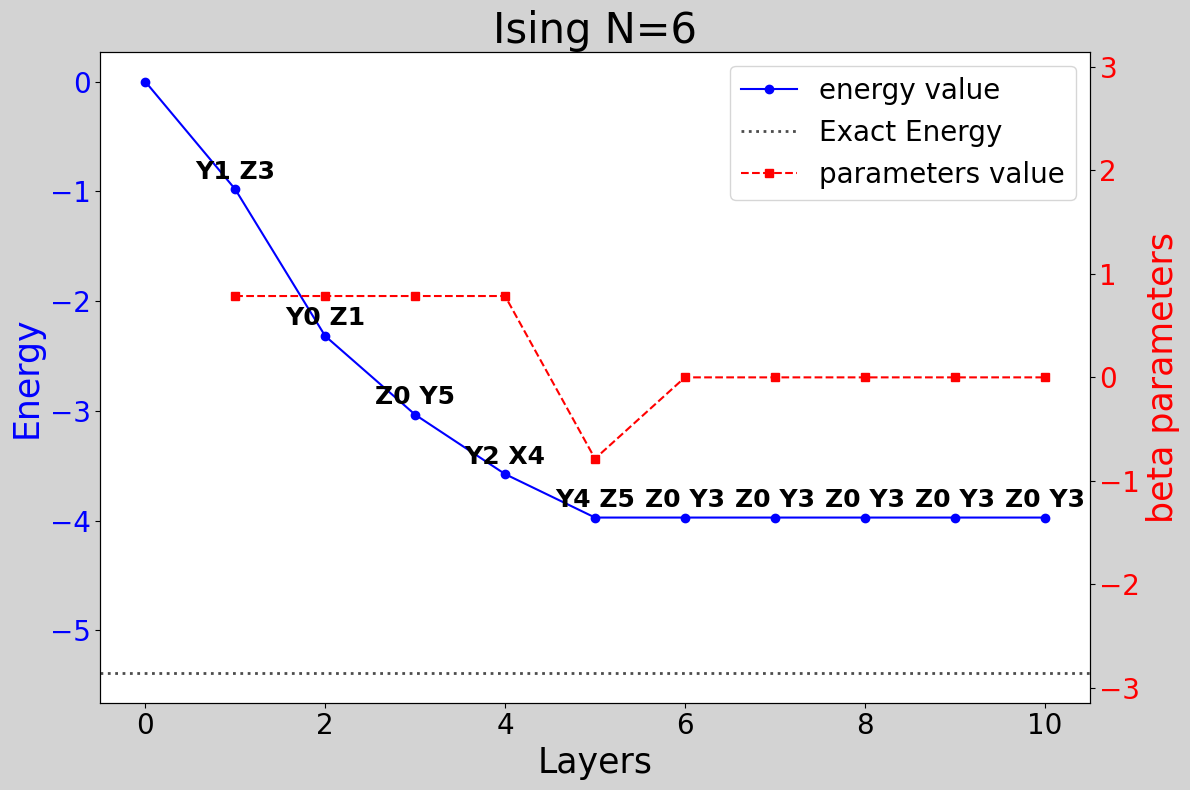

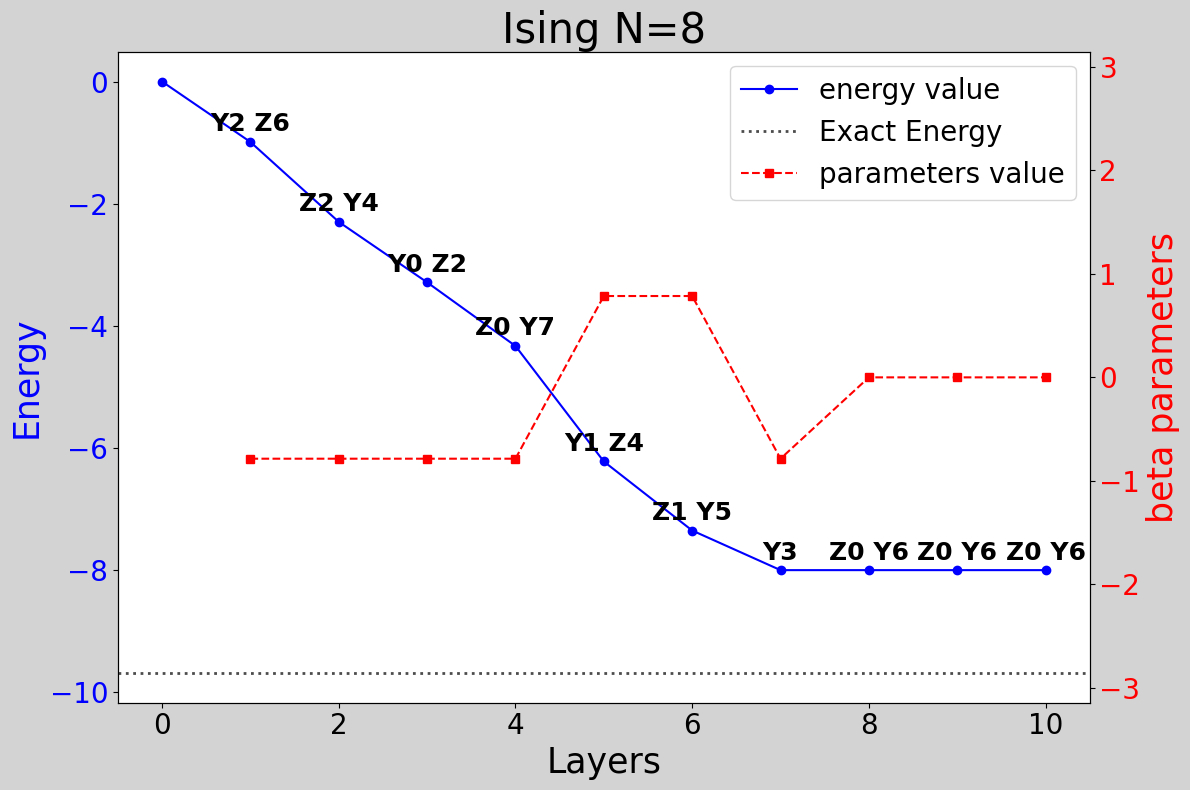

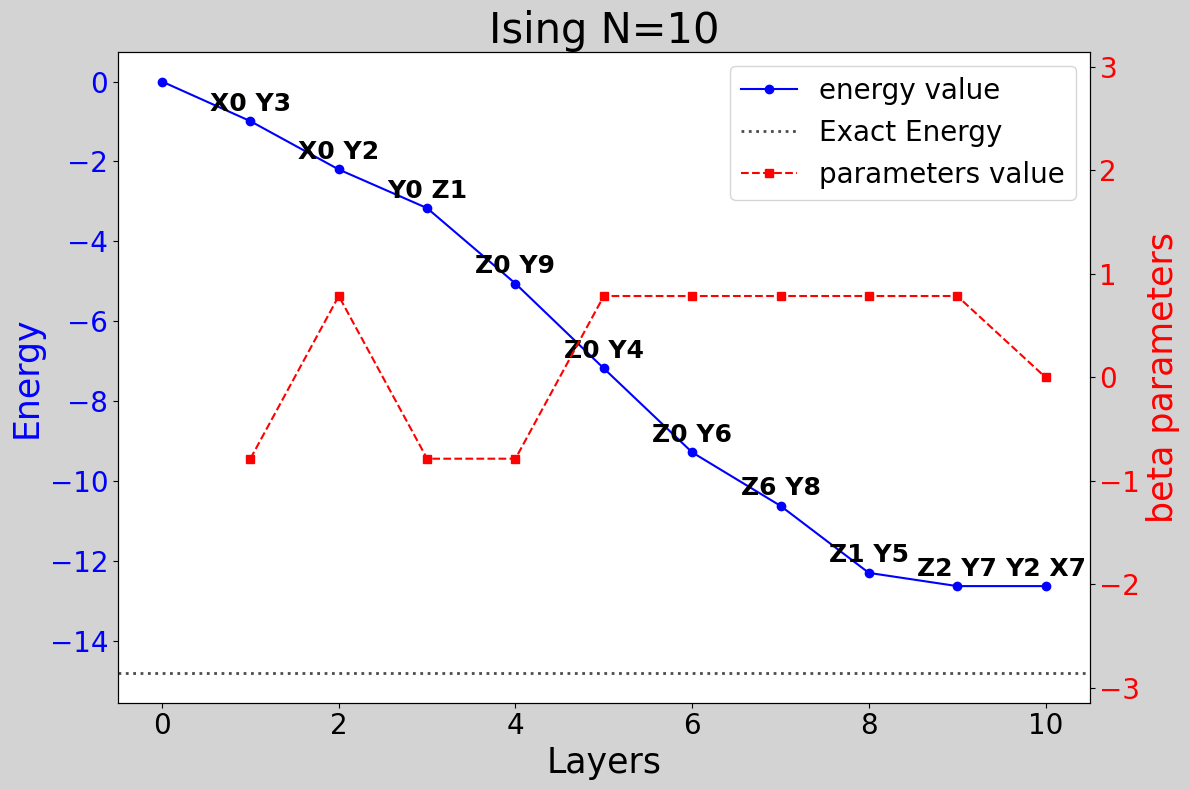

In [17]:
for nbit, layers in [[6,10], [8,10], [10,10]]:
    for i in range(1):
        W = weight_matrix_ising(nbit)
        ham_op = get_ham(nbit, W)
        pool = mixer_double(nbit) + mixer_single(nbit)
        energy = compute_ground_state_energy(W, nbit)
        theta, allthemin, _, mixers_used = ADAPT_QAOA_mixerlayer_only(ham_op, nbit, pool, layers)
    
        fig, ax1 = plt.subplots(figsize=(12, 8), facecolor='lightgray')
    
        ax1.plot(list(range(layers+1)), allthemin, color='b', marker='o', label='energy value')
        ax1.set_xlabel('Layers', fontsize=25)
        ax1.set_ylabel('Energy', fontsize=25, color='b')
        ax1.tick_params(axis='y', labelcolor='blue',labelsize=20)
        ax1.tick_params(axis='x', labelcolor='black',labelsize=20)
        ax1.axhline(y=energy, color='black', linestyle=':', linewidth=2, alpha=0.7, label='Exact Energy')
    
        for x, y, mixer in zip(list(range(1,layers+1)), allthemin[1:], mixers_used):
            ax1.annotate(mixer, xy=(x, y), xytext=(0, 4),
                            textcoords='offset points',
                            ha='center', va='bottom',
                            fontsize=18, color='black',weight='bold')
    
        ax2 = ax1.twinx()
        ax2.plot(list(range(1, layers+1)), [round(num, 4) for num in list(theta.values())],
                         's--', color='r', label='parameters value')
        ax2.set_ylabel('beta parameters', color='red', fontsize=25)
        ax2.tick_params(axis='y', labelcolor='red',labelsize=20)
        ax2.set_ylim(-np.pi, np.pi)
    
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=20)
    
        plt.title(f'Ising N={nbit}', fontsize=30)
        plt.tight_layout()
        plt.show()

# $Figure$ 3
对于 N 比特 Ising 问题，通常需要 N 层双比特门才能求得最优解
不同于 Maxcut 问题的 N-1 层

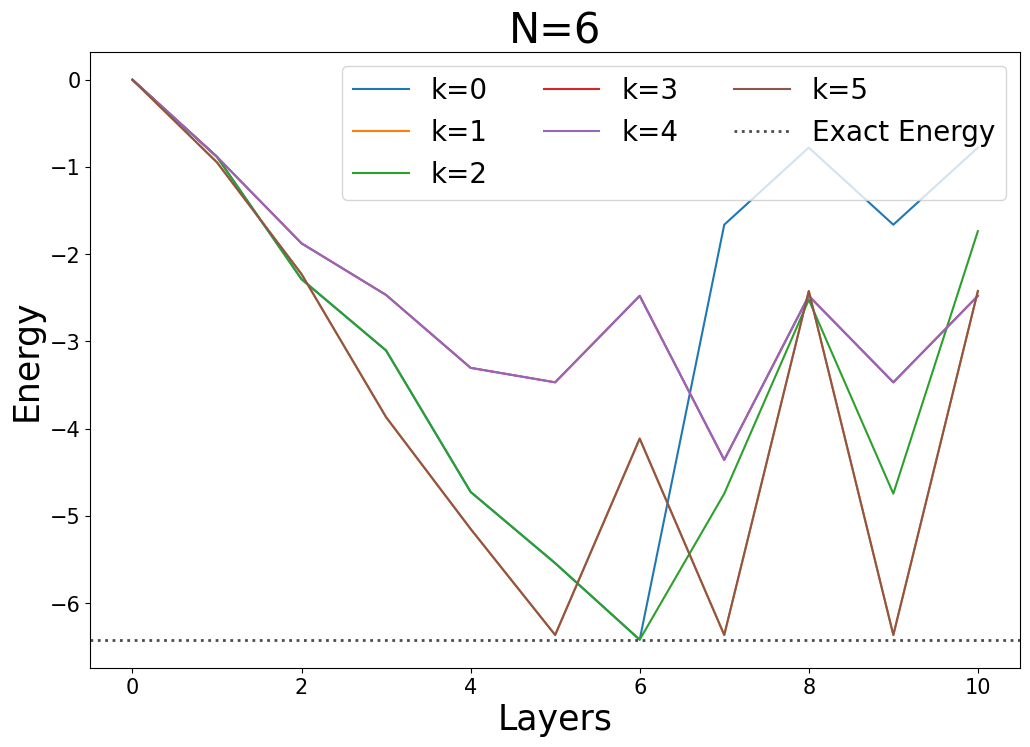

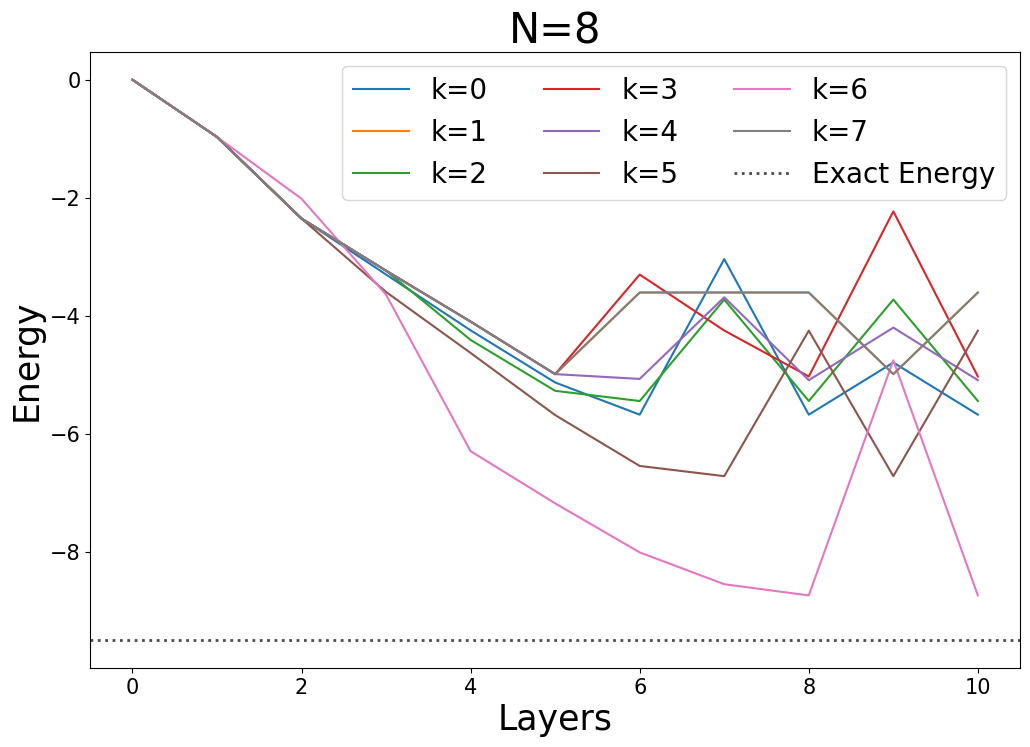

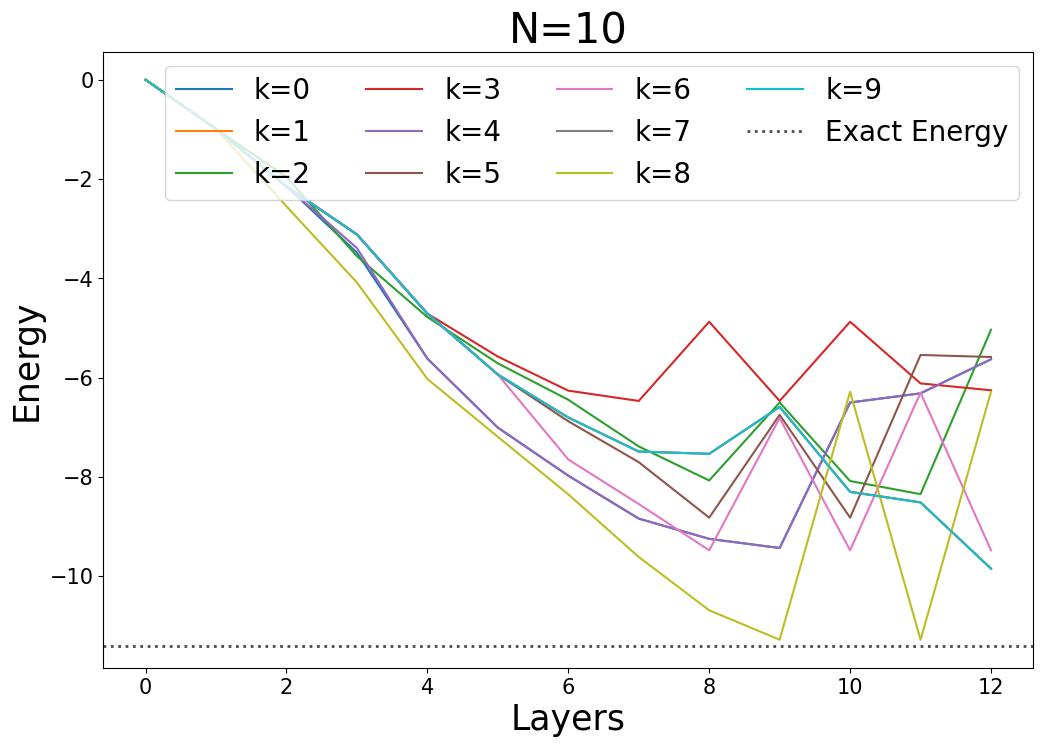

In [23]:
for nbit, layers in [[6,10], [8,10], [10,12]]:
    W = weight_matrix_ising(nbit)
    ham_op = get_ham(nbit, W)
    pool = mixer_pool(nbit)
    energy = compute_ground_state_energy(W, nbit)
    plt.figure(figsize=(12, 8))
    for f in range(nbit):
        _, exps, _ = adapt_clifford_ising_with_pool(nbit, f, ham_op, pool, layers)
        plt.plot(range(layers+1), exps, label=f"k={f}")
    plt.axhline(y=energy, color='black', linestyle=':', linewidth=2, alpha=0.7, label='Exact Energy')
    n_labels = len(plt.gca().get_legend_handles_labels()[1])
    n_cols = int(np.ceil(n_labels / 3))
    plt.legend(ncol=n_cols, fontsize=20, loc="upper right")
    plt.title(f'N={nbit}', fontsize=30)
    plt.xlabel("Layers", fontsize=25)
    plt.ylabel("Energy", fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# $Figure$ 4
算法 B 总是优于算法 A

### nbit=6

i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
i=100


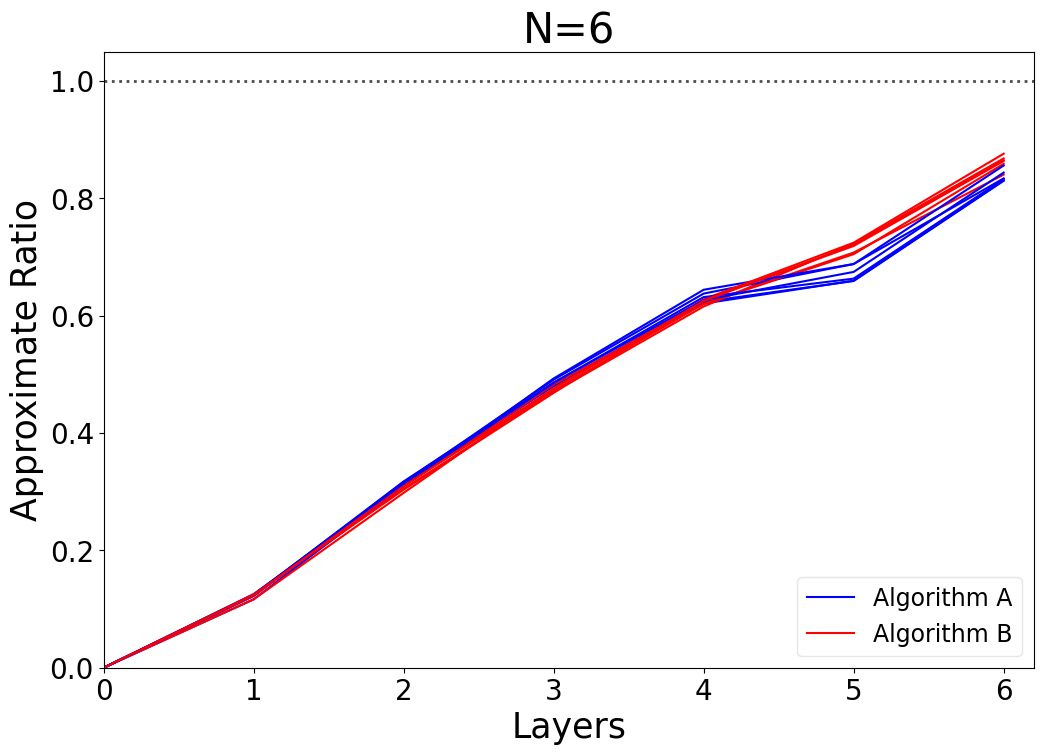

In [24]:
def average_lists(list_of_lists):
    return [sum(values) / len(values) for values in zip(*list_of_lists)]

n = 6
nums = 100
lstA, lstB = [], []
for i in range(nums):
    if (i+1)%10==0: print(f"i={i+1}")
    W = weight_matrix_ising(n)
    ham = get_ham(n, W)
    ground_energy = compute_ground_state_energy(W, n)

    lst_a, lst_b = [], []
    for f in range(n):
        _, expsA, _ = function_algorithm_A(W, ham, f)
        _, expsB, _ = function_algorithm_B(W, ham, f)
        lst_a.append([x/ground_energy for x in expsA])
        lst_b.append([x/ground_energy for x in expsB])
    lstA.append(lst_a)
    lstB.append(lst_b)

A_0 = average_lists([lstA[x][0] for x in range(nums)])
A_1 = average_lists([lstA[x][1] for x in range(nums)])
A_2 = average_lists([lstA[x][2] for x in range(nums)])
A_3 = average_lists([lstA[x][3] for x in range(nums)])
A_4 = average_lists([lstA[x][4] for x in range(nums)])
A_5 = average_lists([lstA[x][5] for x in range(nums)])


B_0 = average_lists([lstB[x][0] for x in range(nums)])
B_1 = average_lists([lstB[x][1] for x in range(nums)])
B_2 = average_lists([lstB[x][2] for x in range(nums)])
B_3 = average_lists([lstB[x][3] for x in range(nums)])
B_4 = average_lists([lstB[x][4] for x in range(nums)])
B_5 = average_lists([lstB[x][5] for x in range(nums)])


A = [average_lists([lstA[x][k] for x in range(nums)]) for k in range(n)]
B = [average_lists([lstB[x][k] for x in range(nums)]) for k in range(n)]

layers = list(range(n+1))
plt.figure(figsize=(12,8))
plt.ylim([0,1.05])
plt.xlim([0,n+0.2])
plt.yticks(ticks=[0,0.2,0.4,0.6,0.8,1], fontsize=20)
plt.xticks(fontsize=20)
for i in range(n):
    if i == 0:
        plt.plot(layers, A[i], linestyle='-', color="b", label="Algorithm A")
        plt.plot(layers, B[i], linestyle='-', color="r", label="Algorithm B")
    else:
        plt.plot(layers, A[i], linestyle='-', color="b")
        plt.plot(layers, B[i], linestyle='-', color="r")
plt.axhline(y=1, color="black", linestyle=":", linewidth=2, alpha=0.7)
plt.legend(fontsize=17, framealpha=0.5)
plt.ylabel("Approximate Ratio", fontsize=25)
plt.xlabel("Layers", fontsize=25)
plt.title(f'N={n}', fontsize=30)
plt.show()

### nbit = 8

i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
i=100


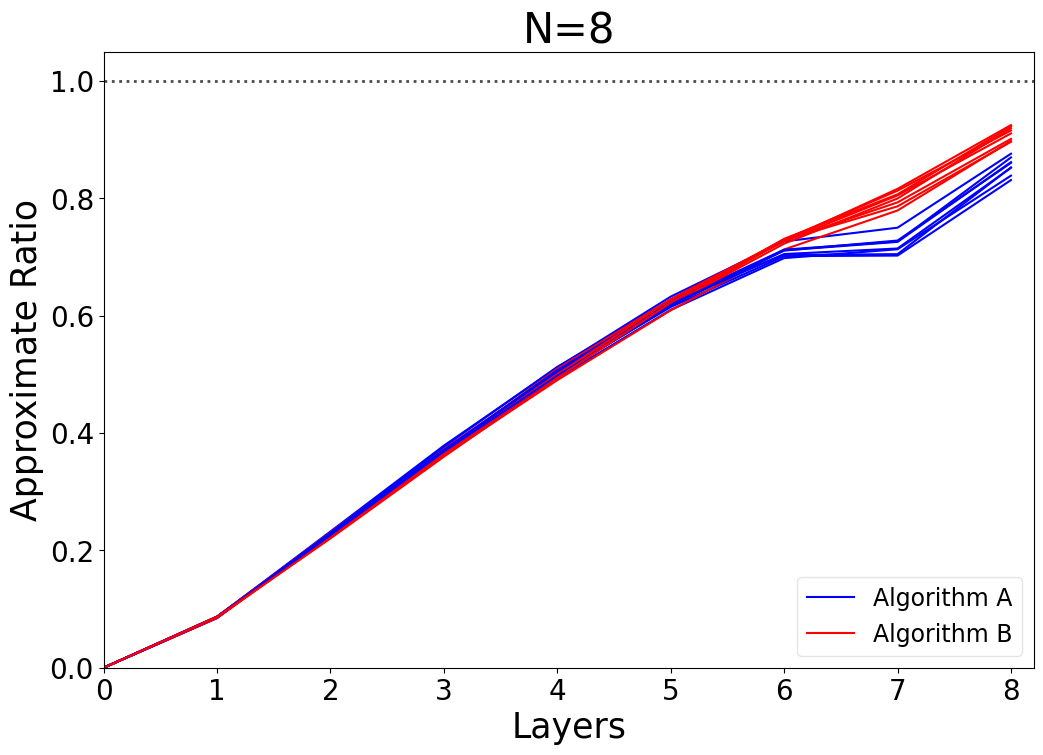

In [25]:
n = 8
nums = 100
lstA, lstB = [], []
for i in range(nums):
    if (i+1)%10==0: print(f"i={i+1}")
    W = weight_matrix_ising(n)
    ham = get_ham(n, W)
    ground_energy = compute_ground_state_energy(W, n)

    lst_a, lst_b = [], []
    for f in range(n):
        _, expsA, _ = function_algorithm_A(W, ham, f)
        _, expsB, _ = function_algorithm_B(W, ham, f)
        lst_a.append([x/ground_energy for x in expsA])
        lst_b.append([x/ground_energy for x in expsB])
    lstA.append(lst_a)
    lstB.append(lst_b)

A_0 = average_lists([lstA[x][0] for x in range(nums)])
A_1 = average_lists([lstA[x][1] for x in range(nums)])
A_2 = average_lists([lstA[x][2] for x in range(nums)])
A_3 = average_lists([lstA[x][3] for x in range(nums)])
A_4 = average_lists([lstA[x][4] for x in range(nums)])
A_5 = average_lists([lstA[x][5] for x in range(nums)])
A_6 = average_lists([lstA[x][6] for x in range(nums)])
A_7 = average_lists([lstA[x][7] for x in range(nums)])

B_0 = average_lists([lstB[x][0] for x in range(nums)])
B_1 = average_lists([lstB[x][1] for x in range(nums)])
B_2 = average_lists([lstB[x][2] for x in range(nums)])
B_3 = average_lists([lstB[x][3] for x in range(nums)])
B_4 = average_lists([lstB[x][4] for x in range(nums)])
B_5 = average_lists([lstB[x][5] for x in range(nums)])
B_6 = average_lists([lstB[x][6] for x in range(nums)])
B_7 = average_lists([lstB[x][7] for x in range(nums)])

A = [average_lists([lstA[x][k] for x in range(nums)]) for k in range(n)]
B = [average_lists([lstB[x][k] for x in range(nums)]) for k in range(n)]

layers = list(range(n+1))
plt.figure(figsize=(12,8))
plt.ylim([0,1.05])
plt.xlim([0,n+0.2])
plt.yticks(ticks=[0,0.2,0.4,0.6,0.8,1], fontsize=20)
plt.xticks(fontsize=20)
for i in range(n):
    if i == 0:
        plt.plot(layers, A[i], linestyle='-', color="b", label="Algorithm A")
        plt.plot(layers, B[i], linestyle='-', color="r", label="Algorithm B")
    else:
        plt.plot(layers, A[i], linestyle='-', color="b")
        plt.plot(layers, B[i], linestyle='-', color="r")
plt.axhline(y=1, color="black", linestyle=":", linewidth=2, alpha=0.7)
plt.legend(fontsize=17, framealpha=0.5)
plt.ylabel("Approximate Ratio", fontsize=25)
plt.xlabel("Layers", fontsize=25)
plt.title(f'N={n}', fontsize=30)
plt.show()

### nbit = 10

i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90
i=100


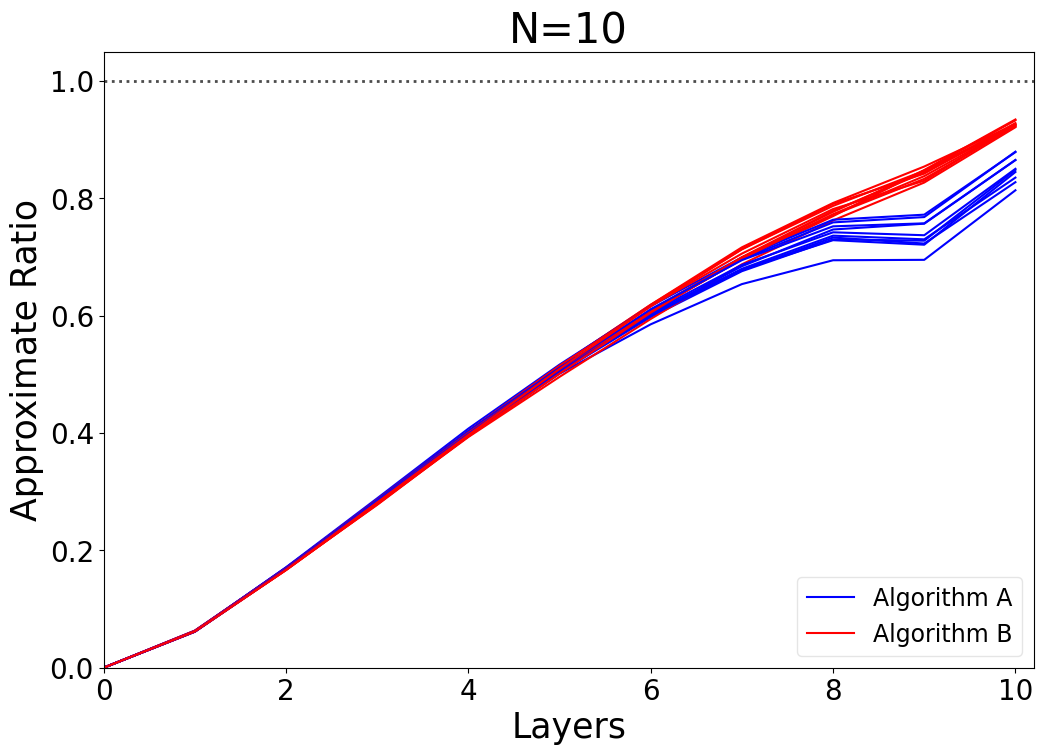

In [26]:
n = 10
nums = 100
lstA, lstB = [], []
for i in range(nums):
    if (i+1)%10==0: print(f"i={i+1}")
    W = weight_matrix_ising(n)
    ham = get_ham(n, W)
    ground_energy = compute_ground_state_energy(W, n)

    lst_a, lst_b = [], []
    for f in range(n):
        _, expsA, _ = function_algorithm_A(W, ham, f)
        _, expsB, _ = function_algorithm_B(W, ham, f)
        lst_a.append([x/ground_energy for x in expsA])
        lst_b.append([x/ground_energy for x in expsB])
    lstA.append(lst_a)
    lstB.append(lst_b)

A_0 = average_lists([lstA[x][0] for x in range(nums)])
A_1 = average_lists([lstA[x][1] for x in range(nums)])
A_2 = average_lists([lstA[x][2] for x in range(nums)])
A_3 = average_lists([lstA[x][3] for x in range(nums)])
A_4 = average_lists([lstA[x][4] for x in range(nums)])
A_5 = average_lists([lstA[x][5] for x in range(nums)])
A_6 = average_lists([lstA[x][6] for x in range(nums)])
A_7 = average_lists([lstA[x][7] for x in range(nums)])
A_8 = average_lists([lstA[x][8] for x in range(nums)])
A_9 = average_lists([lstA[x][9] for x in range(nums)])

B_0 = average_lists([lstB[x][0] for x in range(nums)])
B_1 = average_lists([lstB[x][1] for x in range(nums)])
B_2 = average_lists([lstB[x][2] for x in range(nums)])
B_3 = average_lists([lstB[x][3] for x in range(nums)])
B_4 = average_lists([lstB[x][4] for x in range(nums)])
B_5 = average_lists([lstB[x][5] for x in range(nums)])
B_6 = average_lists([lstB[x][6] for x in range(nums)])
B_7 = average_lists([lstB[x][7] for x in range(nums)])
B_8 = average_lists([lstB[x][8] for x in range(nums)])
B_9 = average_lists([lstB[x][9] for x in range(nums)])

A = [average_lists([lstA[x][k] for x in range(nums)]) for k in range(n)]
B = [average_lists([lstB[x][k] for x in range(nums)]) for k in range(n)]

layers = list(range(n+1))
plt.figure(figsize=(12,8))
plt.ylim([0,1.05])
plt.xlim([0,n+0.2])
plt.yticks(ticks=[0,0.2,0.4,0.6,0.8,1], fontsize=20)
plt.xticks(fontsize=20)
for i in range(n):
    if i == 0:
        plt.plot(layers, A[i], linestyle='-', color="b", label="Algorithm A")
        plt.plot(layers, B[i], linestyle='-', color="r", label="Algorithm B")
    else:
        plt.plot(layers, A[i], linestyle='-', color="b")
        plt.plot(layers, B[i], linestyle='-', color="r")
plt.axhline(y=1, color="black", linestyle=":", linewidth=2, alpha=0.7)
plt.legend(fontsize=17, framealpha=0.5)
plt.ylabel("Approximate Ratio", fontsize=25)
plt.xlabel("Layers", fontsize=25)
plt.title(f'N={n}', fontsize=30)
plt.show()